<a href="https://colab.research.google.com/github/vincent-grari/FAGTB/blob/master/FAGTB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the Github Repository

In [1]:
!pip3 install fairness
!git clone https://github.com/vincent-grari/FAGTB
import urllib.request, sys, os
!bash -c '/content/FAGTB/ProcessedData.py', '/usr/local/lib/python3.6/dist-packages/fairness/data/objects/ProcessedData.py'
sys.path.append('FAGTB')

fatal: destination path 'FAGTB' already exists and is not an empty directory.
/usr/local/lib/python3.6/dist-packages/fairness/data/objects/ProcessedData.py: /content/FAGTB/ProcessedData.py,: No such file or directory


Import all libraries and functions

In [2]:
from functions import *

Available algorithms:
  SVM
  GaussianNB
  LR
  DecisionTree
  Kamishima
  Calders
  ZafarBaseline
  ZafarFairness
  ZafarAccuracy
  Kamishima-accuracy
  Kamishima-DIavgall
  Feldman-SVM
  Feldman-GaussianNB
  Feldman-LR
  Feldman-DecisionTree
  Feldman-SVM-DIavgall
  Feldman-SVM-accuracy
  Feldman-GaussianNB-DIavgall
  Feldman-GaussianNB-accuracy
Instructions for updating:
non-resource variables are not supported in the long term


Import the Adult UCI data set

In [6]:
X_train, X_test, y_train, y_test, sensitive, sensitivet = DATA_TRAIN_TEST(1,'sex',"income-per-year",['sex','income-per-year','race-sex'])  #,'race','race-sex','sex'

Train an unfair GTB:

In [7]:
table = [0,0,0,0]
for k  in range(10):
    np.random.seed()
    X_train, X_test, y_train, y_test, sensitive, sensitivet = DATA_TRAIN_TEST(1,'sex',"income-per-year",['sex','income-per-year','race-sex']) 
    
    gb = GradientBoostingClassifier(n_estimators=500, learning_rate = 0.05, max_depth = 3, max_features=90,random_state=0,  min_impurity_decrease=0.0, min_impurity_split=None,
      min_samples_leaf=2, min_samples_split=2,
      min_weight_fraction_leaf=0.0,
      presort='auto')
    gb.fit(X_train, y_train)

    ##### Results on Test dataset #####
    y_predt2= gb.predict_proba(X_test.values)[:,1]
    print('')
    print('Results on test set :')
    Res = display_results(y_predt2, y_test.values, sensitivet)
    table = np.vstack([table,[Res['Accuracy']*100,Res['PRULE'],Res['DispFPR'],Res['DispFNR']]])


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8652277700417744
PRULE :  34.22051218911598
DI :  0.1684513804981482
DispFPR :  0.06352655329256522
DispFNR :  0.05264617209682687


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8659240103441417
PRULE :  30.46054210936594
DI :  0.18473030121940906
DispFPR :  0.06913046227731592
DispFNR :  0.0884794952038247


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8637358265367018
PRULE :  32.18570354658799
DI :  0.181962574536295
DispFPR :  0.07168981271164862
DispFNR :  0.08595225448536348


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8680127312512433
PRULE :  30.72963799046427
DI :  0.1884137373327146
DispFPR :  0.07242663511854913
DispFNR :  0.09656882761271113


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8642331410383927
PRULE :  30.305491933099887
DI :  0.183950146731739
DispFPR :  0.0655990625915438
DispFNR :  0.10439390934532067


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8665207877461707
PRULE :  34.600799276567194
DI :  0.16962495555000717
DispFPR :  0.06275027017882442
DispFNR :  0.04113210823608249


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8685100457529341
PRULE :  31.321102498898878
DI :  0.183291596677924
DispFPR :  0.06435491865738446
DispFNR :  0.046122978296508355


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8679132683509051
PRULE :  32.06271104763587
DI :  0.17522196635084633
DispFPR :  0.06363065236417662
DispFNR :  0.04622165085738872


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8665207877461707
PRULE :  32.72304171394504
DI :  0.17723712343064435
DispFPR :  0.0640612611127288
DispFNR :  0.053517370053082436


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8651283071414363
PRULE :  33.489883106243624
DI :  0.1702777584070464
DispFPR :  0.05574511203593009
DispFNR :  0.09304958462738855
86.62
32.21
 0.07
 0.07


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


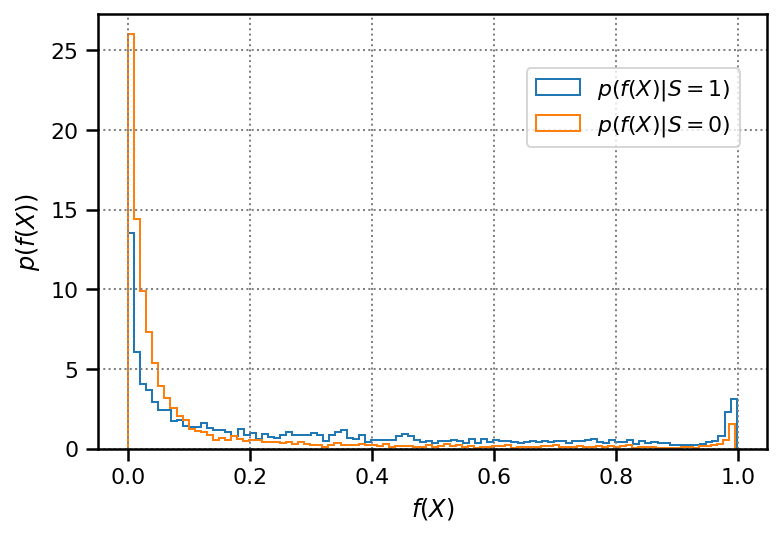

<Figure size 432x432 with 0 Axes>

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

y_pred_S1=gb.predict_proba(X_train)[:,1][sensitive==1]
y_pred_S0=gb.predict_proba(X_train)[:,1][sensitive==0]

fig, ax1 = plt.subplots()
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 16.0
ax1.hist(y_pred_S1, bins=100, density=1, histtype="step", label="$p(f(X)|S=1)$")
ax1.hist(y_pred_S0, bins=100, density=1, histtype="step", label="$p(f(X)|S=0)$")
leg = plt.legend(loc="best")
#plt.ylim(0,15)
plt.xlabel("$f(X)$")
plt.ylabel("$p(f(X))$")
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.8, 0.9),shadow=False, ncol=1)
plt.show()
plt.title('Unfair model (FAGTB with   =0.000)')
plt.savefig("test.pdf" , bbox_inches='tight')
plt.clf() 

plt.show()


Train the FAGTB algorithm on 10 iterations:

In [10]:
table = [0,0,0,0]

for i in range(10):
    X_train, X_test, y_train, y_test, sensitive, sensitivet = DATA_TRAIN_TEST(1,'sex',"income-per-year",['sex','income-per-year','race-sex']) 
   
    classifier= FAGTB(n_estimators=300, learning_rate = 0.01, max_depth = 10,min_samples_split=1.0, min_impurity =False, max_features =20, regression =1)
    y_pred = classifier.fit(X_train.values, y_train.values, sensitive, LAMBDA=0.15, Xtest=X_test.values, yt=y_test,
                      sensitivet=sensitivet)
    
    ##### Results on Test dataset #####
    y_predt2 = classifier.predict(X_test.values)
    print('')
    print('Results on test set :')
    Res = display_results(y_predt2, y_test.values, sensitivet)
    table = np.vstack([table,[Res['Accuracy']*100,Res['PRULE'],Res['DispFPR'],Res['DispFNR']]])
np.savetxt(sys.stdout, np.mean(table[1:,], axis=0).astype(float), '%5.2f')


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


0 11301.400093299457 11229.782312249054 12924.99232624397 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


5 33363.703890390214 11162.209113934096 16166.764697492628 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


10 12778.492561929756 11091.480710896318 13008.254595185783 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


15 16204.969045539041 11030.328156745394 13461.073513576252 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


20 39040.50152088511 10968.784635285909 16824.85986341868 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


25 3496.7293733503925 10905.549461189861 11430.05886719242 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


30 20397.540475517544 10852.860125476445 13912.491196804078 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


35 41980.481547267904 10796.14115310205 17093.213385192234 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


40 3812.1659750569647 10739.348911026496 11311.173807285038 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


45 19328.44426636039 10692.162176815054 13591.428816769116 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


50 41642.14792121191 10640.100456525925 16886.42264470771 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


55 5674.044585747752 10585.199223631083 11436.305911493248 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


60 18854.740769253553 10537.229687924908 13365.44080331294 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


65 41046.32738287876 10485.086652130718 16642.035759562532 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


70 12946.230608851438 10428.61826173446 12370.552853062174 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


75 16403.00101913139 10382.27661785973 12842.726770729438 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


80 38623.18593599205 10332.066111796796 16125.544002195604 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


85 16567.777014644984 10277.220619272035 12762.387171468781 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


90 14440.04332725743 10233.059982438002 12399.066481526617 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


95 37684.658924135125 10183.465543539623 15836.164382159892 Accuracy: 0.7529  test :  0.7475  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: Ru

100 23776.016019286923 10129.119074072249 13695.521476965288 Accuracy: 0.7529  test :  0.7475  Prule Train :  0.0  Prule test :  nan


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


105 11613.880493836747 10085.458591148474 11827.540665223987 Accuracy: 0.7553  test :  0.7484  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


110 36445.12928490082 10039.188212262941 15505.957604998062 Accuracy: 0.7568  test :  0.7505  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


115 25161.092481650114 9987.609967272574 13761.77383952009 Accuracy: 0.7582  test :  0.7509  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


120 11962.852885444454 9947.108477440495 11741.536410257164 Accuracy: 0.7604  test :  0.7516  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


125 37151.85229956213 9903.772429562965 15476.550274497285 Accuracy: 0.7613  test :  0.7525  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


130 27825.687562893218 9855.398601501329 14029.251735935308 Accuracy: 0.7616  test :  0.7527  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


135 11730.021805893859 9819.537766284247 11579.041037168327 Accuracy: 0.7625  test :  0.7538  Prule Train :  0.0  Prule test :  0.017494947191484433


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


140 38841.04403366759 9780.04728337216 15606.203888422297 Accuracy: 0.7638  test :  0.755  Prule Train :  0.004296601324010925  Prule test :  0.04285583963185333
145 23670.057462359546 9736.690706074018 13287.199325427951 Accuracy: 0.7655  test :  0.7566  Prule Train :  0.0133933119396903  Prule test :  0.0671854569228534
150 15020.93849226834 9707.032019635128 11960.172793475378 Accuracy: 0.7678  test :  0.7587  Prule Train :  0.02909777530320269  Prule test :  0.08685333072930933
155 41960.250841457644 9673.303507831339 15967.341134049986 Accuracy: 0.7697  test :  0.7612  Prule Train :  0.0505706173534029  Prule test :  0.1105680662501816
160 20874.361193476132 9636.807038353178 12767.961217374597 Accuracy: 0.7712  test :  0.7626  Prule Train :  0.06630059391139508  Prule test :  0.1341279284680473
165 16211.208676285416 9613.906612813182 12045.587914255995 Accuracy: 0.7786  test :  0.768  Prule Train :  0.23181968059625346  Prule test :  0.26249201774510167
170 45131.23679541912 958

FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


0 11550.630804983684 11262.189038747416 12994.78365949497 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


5 35006.31263795958 11191.558469957203 16442.505365651137 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


10 6221.741332893982 11120.232856450395 12053.494056384494 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


15 19658.454685523444 11061.117124679444 14009.88532750796 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


20 33372.988751193356 10994.762746988896 16000.7110596679 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


25 11891.91546803819 10925.476253166707 12709.263573372435 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


30 18721.236327797247 10866.667884828908 13674.853333998495 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


35 20676.610722803547 10805.191965579594 13906.683574000126 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


40 14419.965676380607 10739.521893683144 12902.516745140234 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


45 39671.664703014285 10680.776242115558 16631.5259475677 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


50 2164.212035850282 10621.426990553704 10946.058795931243 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


55 20903.504367167967 10570.075884163996 13705.601539239193 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


60 33328.623703203484 10512.931687391809 15512.225242872331 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


65 18158.369625163497 10451.124900847344 13174.880344621866 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


70 17379.182249691916 10400.453287139482 13007.330624593269 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


75 43737.86287858423 10350.571482629894 16911.250914417527 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


80 36621.46661932735 10291.971467635623 15785.191460534727 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


85 9310.621632062996 10239.171260038827 11635.764504848275 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


90 36721.01606280874 10187.311983641053 15695.464393062364 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


95 14854.528186801464 10135.5271101396 12363.70633815982 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


100 20552.684465983803 10095.275328791715 13178.177998689287 Accuracy: 0.7513  test :  0.7505  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


105 34306.75344381686 10054.964582892488 15200.977599465015 Accuracy: 0.752  test :  0.7507  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


110 22942.878025653677 10003.595349998763 13445.027053846816 Accuracy: 0.7549  test :  0.7533  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


115 17193.23160708048 9965.274994025482 12544.259735087551 Accuracy: 0.756  test :  0.755  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


120 45641.48959032468 9925.995018339836 16772.21845688854 Accuracy: 0.7569  test :  0.7556  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


125 1117.7066477019775 9887.297126878992 10054.95312403429 Accuracy: 0.7583  test :  0.7571  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


130 22058.21865618305 9844.001245665157 13152.734044092613 Accuracy: 0.7592  test :  0.7577  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


135 18028.99880358944 9811.342290700893 12515.692111239308 Accuracy: 0.7624  test :  0.759  Prule Train :  0.004075367063135016  Prule test :  0.00853513273031616
140 46861.08875700881 9778.517037490212 16807.680351041534 Accuracy: 0.7651  test :  0.7614  Prule Train :  0.005821952947335738  Prule test :  0.009041906236178683
145 11822.59673180943 9741.654864628632 11515.044374400044 Accuracy: 0.7662  test :  0.7618  Prule Train :  0.013488890983615897  Prule test :  0.027244915212591134
150 17460.393735315723 9715.399550636153 12334.458610933512 Accuracy: 0.7678  test :  0.7615  Prule Train :  0.01944591390531429  Prule test :  0.030456947321865033
155 46350.9550974257 9686.256928978226 16638.900193592082 Accuracy: 0.769  test :  0.7627  Prule Train :  0.03246478846904165  Prule test :  0.039990219451066684
160 54004.39048607397 9639.522562835302 17740.181135746396 Accuracy: 0.77  test :  0.7638  Prule Train :  0.05118409345920758  Prule test :  0.05433633794511133
165 3850.5706594890

FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


0 11774.745241770484 11325.053856250246 13091.265642515817 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


5 35711.63055775075 11254.932641647 16611.677225309613 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


10 6148.804586802588 11185.859632210471 12108.18032023086 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


15 19316.517377951 11126.807672147275 14024.285278839925 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


20 37818.32692175334 11065.344287127547 16738.09332539055 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


25 4555.276653466591 10999.117604193387 11682.409102213374 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


30 15916.440596858629 10935.242518298579 13322.708607827371 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


35 17351.40327646372 10879.511416819812 13482.22190828937 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


40 40516.794204885715 10821.654708486989 16899.173839219846 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


45 2604.974591582482 10763.210680330696 11153.956869068068 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


50 6672.486909577439 10701.166063938554 11702.039100375172 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


55 33008.28813753345 10639.577875916455 15590.821096546471 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


60 18824.934328894407 10578.965634548156 13402.705783882317 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


65 17838.159318543276 10531.35793046391 13207.0818282454 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


70 44556.877605106754 10482.341032120763 17165.872672886777 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


75 38960.01189185903 10427.414768672314 16271.416552451168 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


80 9459.798546270316 10374.261025829106 11793.230807769654 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


85 22886.04243404749 10336.025497658095 13768.931862765217 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


90 22355.327075246998 10289.6537902913 13642.952851578351 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


95 45071.185571637194 10247.654224651676 17008.332060397253 Accuracy: 0.7486  test :  0.7561  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


100 548.9211510500049 10202.794559331956 10285.132731989455 Accuracy: 0.7487  test :  0.7563  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


105 16253.52810164073 10153.013497614469 12591.04271286058 Accuracy: 0.7505  test :  0.7574  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


110 20352.187313858936 10118.676638054512 13171.504735133352 Accuracy: 0.7518  test :  0.7579  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


115 29287.156493333998 10077.170720136786 14470.244194136887 Accuracy: 0.7527  test :  0.7594  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


120 37354.04067317756 10022.27749113773 15625.383592114362 Accuracy: 0.7538  test :  0.7595  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


125 11264.527629650369 9981.24744987665 11670.926594324206 Accuracy: 0.7559  test :  0.7615  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


130 40903.627604359026 9940.606747031412 16076.150887685266 Accuracy: 0.7569  test :  0.7625  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


135 14242.540871911162 9898.960966506014 12035.342097292689 Accuracy: 0.7579  test :  0.7636  Prule Train :  0.0  Prule test :  0.005617553525422218


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


140 22919.555840338384 9874.32691613322 13312.260292183977 Accuracy: 0.7599  test :  0.7654  Prule Train :  0.0  Prule test :  0.01740935506977696
145 29352.531445830875 9829.042590775109 14231.92230764974 Accuracy: 0.7612  test :  0.7662  Prule Train :  0.006621739852733198  Prule test :  0.03043210098811406
150 40260.437766616735 9779.47617201562 15818.541837008132 Accuracy: 0.7618  test :  0.7673  Prule Train :  0.01059792699531587  Prule test :  0.03768940166701714
155 11971.204928218525 9745.834428581811 11541.51516781459 Accuracy: 0.7636  test :  0.7687  Prule Train :  0.030507986944693966  Prule test :  0.055388362148749
160 43558.48050885832 9713.66821393709 16247.440290265837 Accuracy: 0.765  test :  0.7701  Prule Train :  0.053157856039997065  Prule test :  0.07857806798813488
165 11651.783364862025 9680.193720800235 11427.96122552954 Accuracy: 0.7722  test :  0.7772  Prule Train :  0.22763565771966485  Prule test :  0.2690042108651048
170 26038.27968780817 9666.10885209314 1

FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


0 11514.006559099942 11268.952130152878 12996.05311401787 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


5 34506.590361948896 11200.99268468696 16376.981238979297 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


10 9141.943071780152 11132.40699839286 12503.698459159883 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


15 18897.509794060352 11073.6129456119 13908.239414720952 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


20 33052.846312616435 11012.968266048 15970.895212940464 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


25 14626.212711954624 10945.298835463793 13139.230742256987 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


30 16898.596333146317 10889.672808473164 13424.462258445114 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


35 41232.262058988366 10831.468665403041 17016.307974251296 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


40 1063.0959617688748 10771.069363524488 10930.53375778982 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


45 14654.512501403222 10715.385188342103 12913.562063552585 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


50 39557.15062242698 10659.426863043089 16592.999456407135 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


55 6258.567710069239 10602.138230813245 11540.923387323632 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


60 19767.003429063534 10554.94855935998 13519.999073719511 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


65 34446.17225935602 10503.274850901767 15670.20068980517 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


70 19887.86716620942 10444.452600561104 13427.632675492518 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


75 15996.620684357955 10396.989317764359 12796.482420418055 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


80 42019.046743515464 10348.096724319645 16650.953735846964 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


85 5713.276460615163 10297.431999024559 11154.423468116835 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


90 13360.19955539183 10251.899395564977 12255.929328873752 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


95 40001.74566835895 10204.552803246372 16204.814653500214 Accuracy: 0.7511  test :  0.751  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: Ru

100 13247.230305999476 10155.069081215177 12142.153627115098 Accuracy: 0.7512  test :  0.751  Prule Train :  0.0  Prule test :  nan


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


105 14776.341401717602 10116.710182052131 12333.16139230977 Accuracy: 0.7543  test :  0.7535  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


110 41981.2113192526 10074.908659823599 16372.090357711488 Accuracy: 0.7551  test :  0.7543  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


115 10030.115823955191 10030.323013744119 11534.840387337399 Accuracy: 0.7562  test :  0.7548  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


120 10385.374630500773 9987.622079980409 11545.428274555527 Accuracy: 0.7575  test :  0.7554  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


125 38403.11087913376 9947.164563310938 15707.631195181 Accuracy: 0.7589  test :  0.7561  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


130 20889.785274434027 9902.844077832735 13036.31186899784 Accuracy: 0.7596  test :  0.757  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


135 18032.51164126417 9873.138526371044 12578.015272560668 Accuracy: 0.7606  test :  0.7583  Prule Train :  0.0  Prule test :  0.011121929363513385


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


140 35661.287373135194 9831.576770660693 15180.769876630971 Accuracy: 0.7622  test :  0.76  Prule Train :  0.0020236684308033515  Prule test :  0.03939016649577658
145 28413.37962276088 9786.952792254071 14048.959735668202 Accuracy: 0.7649  test :  0.7621  Prule Train :  0.016793637325069482  Prule test :  0.07944235259652419
150 15627.12227762097 9757.167311944455 12101.235653587599 Accuracy: 0.7667  test :  0.7641  Prule Train :  0.033914955378433004  Prule test :  0.08862787461549729
155 45054.50108599174 9726.496526798814 16484.67168969757 Accuracy: 0.7691  test :  0.7662  Prule Train :  0.06253082056236953  Prule test :  0.10009736427162047
160 35326.61520674923 9684.927576441587 14983.91985745397 Accuracy: 0.7704  test :  0.7671  Prule Train :  0.07213462604567741  Prule test :  0.09989671090681482
165 13077.568872006043 9654.880576974841 11616.515907775749 Accuracy: 0.7723  test :  0.7678  Prule Train :  0.08406674973380152  Prule test :  0.1067346446982333
170 43551.29286489899

FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


0 11664.573869916921 11303.567350376983 13053.25343086452 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


5 35151.76129460137 11230.514988001481 16503.279182191687 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


10 7780.7757047604655 11158.08288532214 12325.199241036207 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


15 20013.661478328682 11097.072730748356 14099.121952497657 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


20 35786.06729321751 11030.27996303052 16398.190057013144 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


25 8661.43756502835 10961.47787850625 12260.693513260503 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


30 20323.338887020556 10904.813802093633 13953.314635146715 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


35 41874.46579896886 10843.8402388581 17125.010108703427 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


40 6360.428654826936 10783.3072512629 11737.371549486941 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


45 20527.64019942363 10731.936163503924 13811.082193417471 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


50 42069.21332343279 10677.291400895085 16987.673399410003 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


55 3728.254076347001 10619.3338501176 11178.571961569649 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


60 18767.95580402256 10568.321995342689 13383.515365946072 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


65 30572.380527489164 10513.780618310888 15099.63769743426 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


70 27823.75237702936 10449.707297343783 14623.270153898187 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


75 12937.03386033645 10396.905316165214 12337.46039521568 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


80 39806.46563940543 10344.097123666004 16315.06696957682 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


85 10208.128703860606 10290.24657734083 11821.465882919922 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


90 5589.374171239834 10242.883045328072 11081.289171014047 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


95 33343.30178208498 10188.084751005996 15189.580018318742 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:131: Runt

100 25020.91498749333 10131.636150835016 13884.773398959014 Accuracy: 0.7496  test :  0.7541  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


105 16387.270618544353 10090.469723373542 12548.560316155195 Accuracy: 0.7514  test :  0.7555  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


110 45143.34762911533 10049.590208295878 16821.092352663178 Accuracy: 0.7523  test :  0.7562  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


115 2034.9031362807432 10007.258067607589 10312.493538049699 Accuracy: 0.7536  test :  0.7568  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


120 10792.881985829343 9963.690900241758 11582.62319811616 Accuracy: 0.7567  test :  0.7586  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


125 40255.55959212434 9921.529735214617 15959.863674033266 Accuracy: 0.7577  test :  0.7601  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


130 14773.65478202695 9879.449410231415 12095.497627535458 Accuracy: 0.7581  test :  0.7604  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


135 22596.819755690987 9853.91991577233 13243.44287912598 Accuracy: 0.7592  test :  0.7609  Prule Train :  0.0  Prule test :  0.01085591363369141


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


140 51749.18774468083 9827.672523172514 17590.050684874637 Accuracy: 0.7612  test :  0.7626  Prule Train :  0.009982223939243529  Prule test :  0.027824866012568273
145 37690.26451891624 9785.066797962216 15438.606475799654 Accuracy: 0.763  test :  0.7645  Prule Train :  0.015035724808485564  Prule test :  0.04549144760784972
150 11952.895976337539 9750.416449518103 11543.350845968733 Accuracy: 0.7648  test :  0.7664  Prule Train :  0.030618203246370598  Prule test :  0.0677761094427761
155 42460.4523601406 9715.536110105897 16084.603964126987 Accuracy: 0.7665  test :  0.7685  Prule Train :  0.05078733713088456  Prule test :  0.0868473090695313
160 15546.148408298537 9679.472758247346 12011.395019492127 Accuracy: 0.7673  test :  0.7696  Prule Train :  0.07075635203993205  Prule test :  0.11108376741451678
165 23164.349830913583 9660.548521481955 13135.200996118992 Accuracy: 0.7765  test :  0.7771  Prule Train :  0.2599820191824203  Prule test :  0.27885027885027885
170 53822.5902329334

FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


0 11277.82674876056 11189.483658041467 12881.15767035555 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


5 34077.74125681619 11120.772518654523 16232.433707176953 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


10 6901.549477805162 11051.731780335234 12086.964202006011 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


15 19603.237684260956 10994.075853712802 13934.561506351945 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


20 24405.126614787972 10921.920482673635 14582.689474891831 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


25 28411.18306987777 10847.995540348613 15109.67300083028 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


30 10716.586533582158 10785.891574551093 12393.379554588417 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


35 35517.082591745755 10725.052403924841 16052.614792686705 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


40 6215.17120513503 10665.6335770847 11597.909257854953 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


45 22069.63451831446 10616.644654453376 13927.089832200545 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


50 41565.62024830906 10565.861685384038 16800.704722630395 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


55 -3161.43762612847 10511.816884489523 10037.60124057025 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


60 25518.31069468826 10470.55237212177 14298.298976325012 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


65 43857.48316433152 10422.354309405002 17000.976784054732 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


70 -4049.9312015417718 10373.813686136471 9766.324005905206 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


75 19202.635344572518 10333.543199188682 13213.93850087456 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


80 44733.52751551622 10287.425561838203 16997.454689165636 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


85 -1954.294665500879 10241.332866949131 9948.188667123999 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


90 11482.909240291447 10202.962144803045 11925.398530846762 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


95 37322.50332752435 10154.606754043494 15752.982253172146 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


100 16076.149081444662 10104.426757539813 12515.849119756513 Accuracy: 0.7546  test :  0.744  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


105 18353.21561149133 10065.866378535062 12818.84872025876 Accuracy: 0.7561  test :  0.7449  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


110 44326.91612377748 10025.352722407526 16674.390140974152 Accuracy: 0.7582  test :  0.7462  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


115 48856.1483131033 9970.326778319384 17298.74902528488 Accuracy: 0.7589  test :  0.7467  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


120 3541.9794965161773 9919.88767158232 10451.18459605975 Accuracy: 0.7597  test :  0.748  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


125 31383.61692469858 9870.254418646093 14577.79695735088 Accuracy: 0.7611  test :  0.7489  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


130 30550.944406255825 9819.565441986635 14402.207102925007 Accuracy: 0.7617  test :  0.749  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


135 13968.723662465438 9784.421756022557 11879.730305392373 Accuracy: 0.7631  test :  0.7499  Prule Train :  0.0  Prule test :  0.014310437219435488


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


140 42984.56417519812 9749.995378090272 16197.680004369991 Accuracy: 0.764  test :  0.7505  Prule Train :  0.0  Prule test :  0.017755542475966255


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


145 7294.094780732244 9713.633040167302 10807.74725727714 Accuracy: 0.7652  test :  0.7519  Prule Train :  0.0  Prule test :  0.02039998497238676
150 20321.07168613145 9689.155097196313 12737.31585011603 Accuracy: 0.767  test :  0.7545  Prule Train :  0.010874058270551368  Prule test :  0.04507176166976049
155 22658.458456362176 9656.97288742431 13055.741655878635 Accuracy: 0.7687  test :  0.7568  Prule Train :  0.018354302176408363  Prule test :  0.06506138064407634
160 28532.593322628483 9614.513860709378 13894.402859103648 Accuracy: 0.7699  test :  0.759  Prule Train :  0.0368349368161745  Prule test :  0.0844225793196886
165 40448.499879828545 9566.993327630182 15634.268309604464 Accuracy: 0.7713  test :  0.7602  Prule Train :  0.06105138647661256  Prule test :  0.08313288673718303
170 11207.58906054353 9535.745436764024 11216.883795845555 Accuracy: 0.7781  test :  0.7683  Prule Train :  0.2388303694884007  Prule test :  0.2732062503559969
175 42167.010422582745 9506.129600333863 1

FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


0 11416.36531535605 11230.71190134787 12943.166698651277 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


5 34450.625416596966 11159.641031891995 16327.23484438154 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


10 7286.1340171748925 11087.959045489495 12180.87914806573 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


15 19742.89439459336 11029.671131152894 13991.105290341899 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


20 30107.52505338992 10960.815454336089 15476.944212344577 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


25 18148.10649434951 10887.939959489724 13610.155933642149 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


30 15528.418556833145 10828.39058719749 13157.653370722459 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


35 40143.82291634924 10768.218618184887 16789.792055637274 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


40 -414.57658450207225 10710.794351439927 10648.607863764617 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


45 19719.383375344667 10658.142912339563 13616.050418641262 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


50 41059.972847744546 10605.368554195245 16764.364481356926 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


55 977.809254406144 10549.356013507242 10696.027401668165 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


60 21594.50532504359 10501.128717154908 13740.304515911448 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


65 34031.285982505055 10445.544268614518 15550.237165990275 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


70 18514.171298791272 10385.377736363553 13162.503431182242 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


75 16680.914294624992 10339.320288625568 12841.457432819316 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


80 42618.38023835882 10291.547453568011 16684.304489321836 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


85 8552.24552355047 10241.061018994104 11523.897847526674 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


90 854.4554814266461 10195.373023842349 10323.541346056345 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


95 27551.889944768154 10136.98817713124 14269.771668846464 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


100 35633.1736103624 10076.365889177621 15421.341930731982 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


105 10463.638932794784 10030.193461351479 11599.739301270698 Accuracy: 0.7528  test :  0.7477  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


110 38527.91192763105 9985.69610630823 15764.88289545289 Accuracy: 0.7549  test :  0.7489  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


115 13942.059889212416 9938.487737068677 12029.79672045054 Accuracy: 0.7569  test :  0.7497  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


120 21566.494303145268 9906.037563046631 13141.011708518423 Accuracy: 0.758  test :  0.7505  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


125 44452.180452548884 9869.529560690067 16537.3566285724 Accuracy: 0.7595  test :  0.751  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


130 4287.942723098007 9830.711798381471 10473.903206846173 Accuracy: 0.7607  test :  0.7516  Prule Train :  0.0  Prule test :  0.011671449067431849


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


135 18357.03855270677 9797.989863272356 12551.545646178372 Accuracy: 0.7631  test :  0.7531  Prule Train :  0.0  Prule test :  0.024751521298174442


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


140 46976.4007570804 9765.52025674599 16811.980370308047 Accuracy: 0.7643  test :  0.7541  Prule Train :  0.0018704549491985808  Prule test :  0.03148219814241486
145 19698.434278131608 9726.64314844045 12681.408290160192 Accuracy: 0.7664  test :  0.756  Prule Train :  0.0077533374507102485  Prule test :  0.07250445632798573
150 19204.231803129966 9699.373503187031 12580.008273656525 Accuracy: 0.7678  test :  0.7574  Prule Train :  0.016817734878508524  Prule test :  0.0627579556412729
155 44428.40818878269 9670.44125676029 16334.702485077694 Accuracy: 0.7692  test :  0.7585  Prule Train :  0.02595075928232581  Prule test :  0.07281969309462916
160 10460.010636827177 9635.438061682744 11204.439657206822 Accuracy: 0.7705  test :  0.7597  Prule Train :  0.0413384330910104  Prule test :  0.08729928457869635
165 17825.687023414677 9611.549935635643 12285.402989147844 Accuracy: 0.7714  test :  0.7605  Prule Train :  0.044509900180003274  Prule test :  0.09753465717497187
170 37216.715114494

FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


0 11676.179245966105 11303.868764723793 13055.295651618708 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


5 35250.6228796399 11232.239220740787 16519.83265268677 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


10 7345.092981546862 11159.517126929153 12261.28107416118 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


15 20208.10140973544 11099.448870452276 14130.66408191259 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


20 27899.203844700118 11027.141730847397 15212.022307552412 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


25 24312.661060304905 10951.563816366339 14598.462975412072 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


30 13347.227153227775 10888.14343310851 12890.227506092677 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


35 38798.549922279795 10824.24905873393 16644.031547075898 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


40 3206.0563609262394 10763.228037932106 11244.136492071042 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


45 23799.293703201776 10713.55744038581 14283.451495866077 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


50 32611.463443281056 10648.468497389342 15540.1880138815 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


55 18458.364158619763 10584.44248310276 13353.197106895728 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


60 17620.579786593546 10532.553356613118 13175.64032460215 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


65 44424.81657424114 10481.928855187767 17145.651341323937 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


70 -3464.386297037885 10429.693996667103 9910.03605211142 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


75 26610.76829422108 10392.051415113221 14383.666659246383 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


80 50421.02351164914 10350.807662310943 17913.961189058315 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


85 32969.04461690099 10296.293315900646 15241.650008435796 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


90 11149.30144009737 10245.128266184875 11917.52348219948 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


95 38724.202156118765 10194.161197095558 16002.791520513374 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


100 14521.67712147754 10142.214068255595 12320.465636477224 Accuracy: 0.7495  test :  0.7542  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


105 20842.88384037909 10106.011547136663 13232.444123193529 Accuracy: 0.7509  test :  0.7549  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


110 48888.86359463737 10068.490295428519 17401.819834624126 Accuracy: 0.7533  test :  0.7569  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


115 -2484.836583059415 10029.298232068268 9656.572744609355 Accuracy: 0.7564  test :  0.7581  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


120 21472.832060315952 9998.731817764645 13219.656626812035 Accuracy: 0.7576  test :  0.7592  Prule Train :  0.0  Prule test :  0.007368683096838437


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


125 49424.18854361292 9965.259306162341 17378.887587704277 Accuracy: 0.7585  test :  0.76  Prule Train :  0.0  Prule test :  0.012944983818770225


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


130 20238.964324399873 9921.918153113329 12957.76280177331 Accuracy: 0.7598  test :  0.7604  Prule Train :  0.0  Prule test :  0.017739422270166606
135 18254.377252532657 9891.48822817431 12629.64481605421 Accuracy: 0.7614  test :  0.7617  Prule Train :  0.0037247200181727068  Prule test :  0.02547682985609034
140 46541.10982355656 9858.337089864282 16839.503563397764 Accuracy: 0.7631  test :  0.7631  Prule Train :  0.009299784819566694  Prule test :  0.026609133405249907
145 27466.972694356176 9815.346079568348 13935.391983721773 Accuracy: 0.7648  test :  0.7641  Prule Train :  0.014722500573223038  Prule test :  0.033969106474787125
150 15336.66064309712 9783.505691540147 12084.004788004715 Accuracy: 0.7659  test :  0.765  Prule Train :  0.027744764859774652  Prule test :  0.044624012542965684
155 44055.84828049544 9749.815791884106 16358.193033958425 Accuracy: 0.7675  test :  0.7663  Prule Train :  0.052721972127551836  Prule test :  0.05473878871937124
160 60774.9915976381 9700.320

FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


0 11684.099951832537 11316.885174646251 13069.50016742113 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


5 34999.290455475704 11246.267674640158 16496.161242961516 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


10 9458.107207463265 11174.799918420877 12593.515999540365 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


15 19033.26800929833 11116.263345574112 13971.25354696886 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


20 34350.28951463264 11055.023330231837 16207.566757426734 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


25 13457.666607774703 10983.986520720922 13002.636511887127 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


30 17700.44859365657 10928.401458181546 13583.46874723003 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


35 42178.40495818098 10871.06625951427 17197.82700324142 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


40 13012.630301387195 10809.95081736762 12761.845362575701 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


45 18389.276625141178 10758.586888598791 13516.978382369965 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


50 41993.85665297265 10702.527719234968 17001.606217180866 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


55 6702.900638791722 10643.058300597457 11648.493396416214 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


60 16952.226221166693 10594.265660799227 13137.099593974228 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


65 42016.31344914269 10544.01067349068 16846.45769086208 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


70 27721.666257868004 10484.03461251694 14642.284551197139 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


75 12292.141520172716 10431.60807648651 12275.429304512414 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


80 38569.82995009556 10378.980042109459 16164.454534623794 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


85 15530.898953163229 10325.070023111091 12654.704866085576 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


90 7846.628762985943 10278.609619244373 11455.603933692266 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


95 34949.64884763773 10225.150142616534 15467.597469762195 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


100 24801.06812605184 10169.342816603896 13889.50303551167 Accuracy: 0.7489  test :  0.7554  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


105 15621.950468486753 10129.170358573534 12472.462928846548 Accuracy: 0.7505  test :  0.7566  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


110 33929.96554270338 10085.674491977585 15175.16932338309 Accuracy: 0.7526  test :  0.7579  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


115 28909.59183146771 10031.950099077358 14368.388873797514 Accuracy: 0.7537  test :  0.7585  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


120 14570.55520122045 9993.473574976128 12179.056855159193 Accuracy: 0.7563  test :  0.7598  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


125 43374.69920893739 9954.10008309725 16460.30496443786 Accuracy: 0.7576  test :  0.7605  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


130 28215.59890364117 9907.73455908561 14140.074394631783 Accuracy: 0.7582  test :  0.761  Prule Train :  0.0  Prule test :  0.01276935986953562


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


135 15639.147816597038 9874.017644724912 12219.889817214467 Accuracy: 0.7591  test :  0.7619  Prule Train :  0.00223965848965849  Prule test :  0.016481383087423876
140 45152.19112495889 9840.28481687693 16613.113485620765 Accuracy: 0.761  test :  0.7634  Prule Train :  0.005713774414561817  Prule test :  0.03274519016049232
145 24124.591523244148 9799.585064947343 13418.273793433964 Accuracy: 0.7632  test :  0.7651  Prule Train :  0.015406567954338654  Prule test :  0.05653443087537991
150 18134.835776378655 9772.451625106753 12492.676991563552 Accuracy: 0.7656  test :  0.7663  Prule Train :  0.027382994364126438  Prule test :  0.06065445938029418
155 44478.33142996181 9743.272017320156 16415.021731814428 Accuracy: 0.7673  test :  0.7679  Prule Train :  0.0436480812420662  Prule test :  0.07382286174575278
160 13973.62689681795 9707.720274671236 11803.764309193928 Accuracy: 0.7688  test :  0.7689  Prule Train :  0.060037814214425195  Prule test :  0.07919955572261107
165 18920.3710597

FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


0 11802.536126843963 11334.35723301963 13104.737652046224 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


5 35738.767220535694 11265.72261071521 16626.537693795563 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


10 6610.913846282015 11198.3547377047 12189.991814647 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


15 20194.537469002575 11142.962218621675 14172.142838972064 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


20 27837.128682833856 11072.359007900039 15247.928310325118 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


25 24997.31136977803 10998.265681827277 14747.86238729398 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


30 13307.083975477944 10938.346847339528 12934.409443661218 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


35 39013.53601163013 10877.78899810764 16729.81939985216 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


40 3474.8522813247473 10816.874952192538 11338.10279439125 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


45 19675.972763178823 10767.51433076472 13718.910245241543 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


50 45222.11687377946 10716.843090744329 17500.160621811243 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


55 45529.53178781256 10662.45801228613 17491.887780458015 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


60 43140.52510981946 10607.677056456443 17078.75582292936 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


65 5.514415244009732 10554.920649542039 10555.747811828638 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


70 20401.825550336853 10510.436977772151 13570.710810322678 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


75 42580.53912168407 10463.820089032899 16850.90095728551 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


80 4786.564792122208 10413.593787968111 11131.578506786442 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


85 7044.2882278000425 10370.361632708822 11427.00486687883 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


90 34244.772527104025 10317.854150057174 15454.570029122779 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


95 24242.915447998595 10263.481757400903 13899.91907460069 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:131: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


100 16073.001222425537 10223.08341093209 12634.033594295921 Accuracy: 0.7481  test :  0.757  Prule Train :  nan  Prule test :  nan


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


105 44141.2597998885 10181.798862383343 16802.98783236662 Accuracy: 0.7499  test :  0.7587  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


110 28225.273836379303 10132.69557323872 14366.486648695613 Accuracy: 0.7508  test :  0.7594  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


115 14851.19110766215 10094.362253207797 12322.04091935712 Accuracy: 0.7523  test :  0.7601  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


120 43657.87057944514 10055.77663194453 16604.457218861302 Accuracy: 0.7544  test :  0.7614  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


125 17659.422337020802 10012.9122635232 12661.825614076322 Accuracy: 0.7556  test :  0.7627  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


130 15049.311001221835 9981.41812814865 12238.814778331925 Accuracy: 0.7565  test :  0.7634  Prule Train :  0.0  Prule test :  0.0


FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100
FAGTB/functions.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  return np.min([odds, 1/odds]) * 100


135 44288.16928096663 9945.919201191113 16589.144593336106 Accuracy: 0.7588  test :  0.7643  Prule Train :  0.0061158279404975235  Prule test :  0.004817980840088431
140 60028.16589877308 9893.149604068121 18897.37448888408 Accuracy: 0.7595  test :  0.7652  Prule Train :  0.005592294031194234  Prule test :  0.022100829541690046
145 1510.6575633023322 9846.622681203093 10073.221315698444 Accuracy: 0.7606  test :  0.7666  Prule Train :  0.0118081419743174  Prule test :  0.03108374735540923
150 32569.344368660997 9803.63395157748 14689.035606876627 Accuracy: 0.7622  test :  0.7684  Prule Train :  0.03650081437503284  Prule test :  0.04887806649365074
155 33899.66406884363 9758.43923925603 14843.388849582574 Accuracy: 0.7635  test :  0.7693  Prule Train :  0.05754632896964637  Prule test :  0.06691640055678376
160 15707.458661770783 9731.047149104174 12087.165948369791 Accuracy: 0.7716  test :  0.778  Prule Train :  0.26355888889708523  Prule test :  0.2920900884303611
165 47837.4375471805

Results for FAGTB with logistic regression on Adversarial

In [11]:
np.set_printoptions(suppress=True) 
np.mean(table[1:,], axis=0).astype(float)

array([84.11080167, 86.73278571,  0.03408385,  0.27099708])